In [1]:
from collections import Counter
from pprint import pprint
from pathlib import Path
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
from helper import Preprocess
from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy import linalg as LA

from sklearn.manifold import TSNE

In [2]:
FILE_NAME = 'graphsage_128_128_relu_20_5_adjacentTF_1e-4'
DATA_DIR = Path("../../data/")

we first explore the original graph (before embedding)

In [3]:
data_processor = Preprocess()
df = data_processor.raw2train(DATA_DIR)

G_original = nx.from_pandas_edgelist(df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
print(nx.info(G_original))

Raw data:
Shape of GM12878: (506074, 5)
Shape of K562: (954968, 5)
Shape of PPI: (21038, 3)
-----------------------------------------
After processing:
Number of GM12878 edges: 354514
Number of K562 edges: 390088
Number of PPI edges (Undirectional): 21038
--------
Number of TFs: 69
-----------------------------------------
Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 761241
Average degree:  81.9729


We first map the vectors in embedded space to a graph using KNN algorithm

In [4]:
emb_df = pd.read_csv(f'./emb/{FILE_NAME}.csv', index_col=0)
emb_df = emb_df.drop(['type'], axis='columns')

# map node index to node name
idx = emb_df.index
idx2name = dict()
for i, name in enumerate(idx):
    idx2name[i] = name
emb = emb_df.to_numpy()

# use KNN to find nearest neighbors of every node
print('Running KNN...')
nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(emb)
distance, indices = nbrs.kneighbors(emb)
print('KNN completed!')

# create edgelist
edgelist = []
print('Creating edgelist...')
for i, name in enumerate(idx):
    for j in range(len(indices[i])):
        temp = []
        if j != 0:
            temp.append(name)
            temp.append(idx2name[indices[i][j]])
            temp.append(distance[i][j])
            edgelist.append(temp)

edgelist_df = pd.DataFrame(edgelist)
edgelist_df.columns = ['source', 'target', 'distance']
# edgelist_df['weight'] = edgelist_df['distance'].map(lambda x: 1-x)
edgelist_df.shape

edgelist_df.head()

Running KNN...
KNN completed!
Creating edgelist...


source   target  distance
0  MCHR1  ONECUT3  0.127964
1  MCHR1    KCNS3  0.144088
2  MCHR1  COL11A2  0.148089
3  MCHR1      CLC  0.150352
4  MCHR1    OR4N2  0.167813

In [5]:
# G = nx.from_pandas_edgelist(edgelist_df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
G = nx.from_pandas_edgelist(edgelist_df[['source', 'target']], 'source', 'target', create_using=nx.Graph)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 707991
Average degree:  76.2387


In [6]:
# Run Louvein algorithm for clustering
partition = community_louvain.best_partition(G, resolution=1.5, random_state=0)
max(set(partition.values()))

7

Now we have a clustered network based on the embedding of each node, we create a new column to record class of each node.

In [7]:
emb_df['class'] = emb_df.index.map(lambda x: partition[x])
cluster_df = emb_df[['class']].copy(deep=True)
cluster_df.groupby(['class'])
def is_tf(name):
    if name[-3:] == '_gm':
        return 2
    elif name[-2:] == '_k':
        return 1
    else:
        return 0
cluster_df['is_tf'] = cluster_df.index.map(lambda name: is_tf(name))

gm_cluster_df = cluster_df[cluster_df['is_tf'] == 2]
k_cluster_df = cluster_df[cluster_df['is_tf'] == 1]
gene_cluster_df = cluster_df[cluster_df['is_tf'] == 0]

print('Cluster of K: ', Counter(k_cluster_df['class']))
print('Cluster of GM: ', Counter(gm_cluster_df['class']))
print('Cluster of normal gene: ', Counter(gene_cluster_df['class']))

Cluster of K:  Counter({6: 69})
Cluster of GM:  Counter({6: 69})
Cluster of normal gene:  Counter({0: 4946, 4: 4541, 1: 4459, 2: 3174, 3: 626, 7: 378, 5: 309, 6: 2})


In [8]:
mean_clusters = emb_df.groupby('class').mean()

all_embeddings = emb_df.drop(['class'], axis=1).append(mean_clusters)

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=all_embeddings.index)

print('Mapping names to classes...')
def name2class(name):
    if type(name) == int:
        return 10
    else:
        if name[-2:] == '_k':
            return 1
        elif name[-3:] == '_gm':
            return 2
        else:
            return 0
emb_transformed['type'] = emb_transformed.index.map(name2class)
emb_transformed



Running TSNE...
Mapping names to classes...


0          1  type
MCHR1    9.692060   0.064089     0
PSMD9  -42.841595 -28.534750     0
CRIP1  -34.666386  26.051140     0
GIMAP4 -21.881254   5.136426     0
GATM    66.650322  -5.983624     0
...           ...        ...   ...
3      -19.935148   4.596067    10
4       42.912571 -14.105024    10
5      -10.310485  57.339981    10
6      -74.798729 -13.149342    10
7      -31.646986  -6.045703    10

[18581 rows x 3 columns]

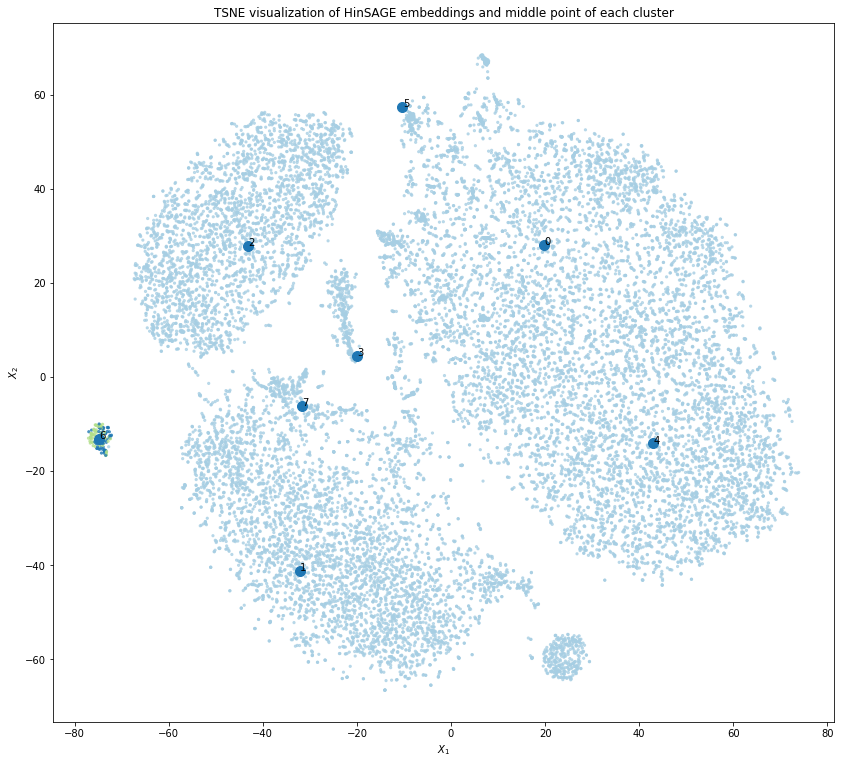

In [9]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=5
)
ax.scatter(
    emb_transformed[emb_transformed['type'] == 10][0],
    emb_transformed[emb_transformed['type'] == 10][1],
    s=100
)

# Annotate ID of each cluster
n_clusters = max(set(partition.values())) + 1
for i in range(n_clusters):
    ax.annotate(str(i), (emb_transformed[emb_transformed['type'] == 10].loc[i][0]+.05, emb_transformed[emb_transformed['type'] == 10].loc[i][1]+.05))
# for i, txt in enumerate(nodes):
#     if txt in target_txts or False:
#         ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))


ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings and middle point of each cluster")

# plt.savefig(f'./img/{file_name}_TF.png', dpi=150)
plt.show()

We could also color the graph by the class of each node

In [10]:
# _idx = list(emb_df.columns)[:-1]

# print('Running TSNE...')
# trans = TSNE(n_components=2, random_state=0)
# emb_transformed = pd.DataFrame(trans.fit_transform(emb_df[_idx]), index=emb_df.index)
# emb_transformed['class'] = emb_df['class']

# fig, ax = plt.subplots(figsize=(14, 14))
# ax.scatter(
#     emb_transformed[0],
#     emb_transformed[1],
#     c=emb_transformed["class"],
#     # cmap="inferno",
#     alpha=alpha,
#     s=5
# )

# ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
# plt.title(f"TSNE visualization of HinSAGE embeddings colored by class")

# # plt.savefig(f'./img/{file_name}_TF.png', dpi=150)
# plt.show()

We could calculate the distance between clusters, the distance is defined as how many hops are needed from one node to another

In [11]:
gms = list(gm_cluster_df.index)
ks = list(k_cluster_df.index)
genes = list(gene_cluster_df.index)

print(len(genes))
cluster_df

18435


class  is_tf
MCHR1         0      0
PSMD9         1      0
CRIP1         2      0
GIMAP4        3      0
GATM          4      0
...         ...    ...
ERCC5         1      0
MARVELD1      0      0
YTHDC2        2      0
SRC           1      0
C1GALT1       4      0

[18573 rows x 2 columns]

In [12]:
shortest_paths = {}
tfs = gms + ks

shortest_paths_df = pd.DataFrame(index=genes, columns=tfs, dtype=np.int16)

for tf in tfs:
    shortest_paths[tf] = nx.shortest_path_length(G_original, source=tf)


In [13]:
shortest_paths_df = pd.DataFrame(shortest_paths)
shortest_paths_df = shortest_paths_df[~shortest_paths_df.index.isin(tfs)]
shortest_paths_df.sort_index(inplace=True)

shortest_paths_cluster = cluster_df[cluster_df.index.isin(shortest_paths_df.index)].sort_index()
# shortest_paths_cluster
shortest_paths_df['cluster'] = shortest_paths_cluster['class']

# Mode
# shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').agg(lambda x:x.value_counts().index[0]).to_frame()

# Mean
shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').mean().to_frame().sort_values([0])

0
cluster          
2        1.785659
1        1.830496
7        1.934323
6        2.119565
3        2.223793
4        2.240533
0        2.822707
5        3.014324

In [14]:
shortest_paths_df.columns 

Index(['EZH2_gm', 'TARDBP_gm', 'E2F4_gm', 'JUND_gm', 'ATF3_gm', 'SPI1_gm',
       'ELK1_gm', 'HDGF_gm', 'BHLHE40_gm', 'NFYB_gm',
       ...
       'ZBED1_k', 'POLR3G_k', 'SUZ12_k', 'ATF3_k', 'NRF1_k', 'MAX_k', 'ETS1_k',
       'NFYB_k', 'SMAD5_k', 'cluster'],
      dtype='object', length=139)